In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time

path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


# Load dataset

In [51]:
#load in dataset as compressed numpy (for storage) 
X_=np.load(datapath+"X_sandpaper_pressip.npz")
for array_name in X_:
    X=X_[array_name]#.astype(np.uint8)
y_=np.load(datapath+"y_sandpaper_pressip.npz")
for array_name in y_:
    y=y_[array_name]#.astype(np.uint8)
y[y==3]=180 #put as sandpaper vaue to make clearer
y[y==4]=120
y[y==0]=80

#convert it all to voltages
X=(X* 3.3) / 65536
#remove unneeded columns
vibration_X=X[:,:,8]
X=X[:,:,[i for i in range(8)]+[8,12,13,14,15]] #all data but gyro

print("Vibration X data",vibration_X.shape)
print("y data",y.shape)
print("X data (num readings, timestep, sensor channel)",X.shape)
trial_time=1719216609.4364703-1719216600.0451353
print("Time per step",trial_time/X.shape[1],"seconds")

Vibration X data (1000, 100)
y data (1000,)
X data (num readings, timestep, sensor channel) (1000, 100, 13)
Time per step 0.09391335010528565 seconds


# Visualise

400 400 0


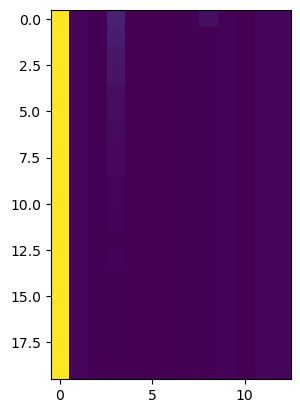

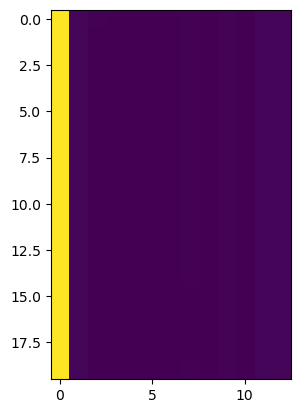

In [47]:
#split them up for vis
d120=X[np.where(y==120)]
d180=X[np.where(y==180)]
d80=X[np.where(y==80)]
print(len(d120),len(d180),len(d80))
averaged120=np.average(d120,axis=0)
averaged180=np.average(d180,axis=0)
averaged80=np.average(d80,axis=0)

plt.imshow(averaged120)
plt.show()
plt.imshow(averaged180)
plt.show()
#plt.imshow(averaged80)
#plt.show()

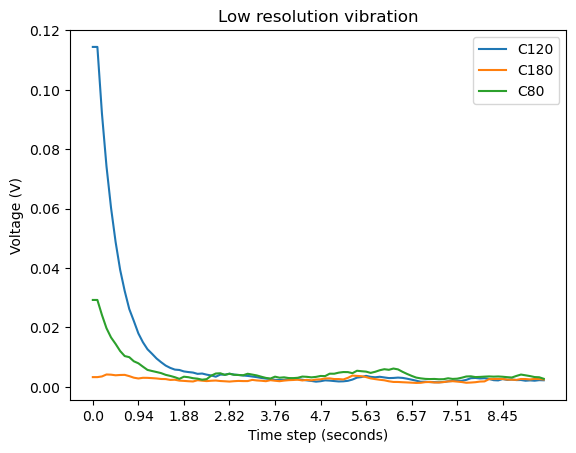

In [81]:
def low_pass_filter(data,alpha=0.8):
    y=np.zeros(data.shape)
    y[0]=data[0]
    for i in range(len(y)-1):
        y[i+1]=y[i]*alpha + (1-alpha)*data[i]
    return y

#split them up for vis
d120=vibration_X[np.where(y==120)]
d180=vibration_X[np.where(y==180)]
d80=vibration_X[np.where(y==80)]

#get average of all trials
averaged120=np.average(d120,axis=0)
averaged180=np.average(d180,axis=0)
averaged80=np.average(d80,axis=0)

#low pass filter
sampling_rate=trial_time/X.shape[1]

filtered_averaged120 = low_pass_filter(averaged120)
filtered_averaged180 = low_pass_filter(averaged180)
filtered_averaged80 = low_pass_filter(averaged80)

plt.ylabel("Voltage (V)")
plt.xlabel("Time step (seconds)")
plt.xticks([i for i in range(0,len(averaged120),10)],[round(trial_time/X.shape[1]*i,2) for i in range(0,len(averaged120),10)])
plt.plot(filtered_averaged120,label="C120")
plt.plot(filtered_averaged180,label="C180")
plt.plot(filtered_averaged80,label="C80")
plt.legend(loc="upper right")
plt.title("Low resolution vibration")
plt.show()

In [37]:
X[12]

array([[3.1453125 , 0.03867187, 0.        , 0.6703125 , 0.        ,
        0.        , 0.01289062, 0.01289062, 0.        , 3.28710938,
        3.28710938, 3.28710938, 0.02578125, 0.        , 0.0515625 ,
        0.03867187],
       [3.15820312, 0.03867187, 0.        , 0.01289062, 0.        ,
        0.        , 0.01289062, 0.01289062, 0.        , 3.28710938,
        3.28710938, 3.28710938, 0.02578125, 0.        , 0.03867187,
        0.03867187],
       [3.1453125 , 0.03867187, 0.        , 0.        , 0.        ,
        0.        , 0.01289062, 0.01289062, 0.        , 3.28710938,
        3.28710938, 3.28710938, 0.02578125, 0.        , 0.0515625 ,
        0.03867187],
       [3.15820312, 0.03867187, 0.        , 0.        , 0.        ,
        0.        , 0.01289062, 0.01289062, 0.        , 3.28710938,
        3.28710938, 3.28710938, 0.02578125, 0.01289062, 0.0515625 ,
        0.03867187],
       [3.1453125 , 0.03867187, 0.        , 0.        , 0.        ,
        0.        , 0.01289062, 